# Parte 1 - Teleporte local 

A aplicação do teleporte pode ser feita localmente entre qubits que compartilham o mesmo chip. Essa aplicação, apesar de não possuir muita utilidade prática para a realização de circuitos quânticos, demonstra um conceito de grande importância em sistemas quânticos distribuídos. 

Agora, vamos realizar a aplicação do teleporte local dentro do ambiente do qlm. Vamos iniciar importando as bibliotecas necessárias.

In [1]:
from qat.lang.AQASM import Program, H, X, Z, CNOT, AbstractGate
import numpy as np

# Criando o circuito

Montaremos o nosso circuito como na imagem abaixo: <br> <br>

<div>
<img src="teleporte.png" width="400">
<!-- <figcaption>Fig 1 : Circuito do teleporte.<figcaption>     -->
    


Para isso, vamos alocar os qubits de Alice e Bob, assim como os bits clássicos que armazenará a informação após a medida. <br> <br>

In [2]:
# Criação do programa
qprog = Program() 

# Alocando os bits quânticos de Alice
Alice = qprog.qalloc(2)
# Alocando os bits clássicos de Alice
Cra0 = qprog.calloc(1)
Cra1 = qprog.calloc(1)
# Alocando o bit quânticos de Bob
Bob = qprog.qalloc(1)
# Alocando o bit clássico de Bob
Crb = qprog.calloc(1)

# Preparando o Estado $\vert \psi \rangle$ que será teleportado

Neste exemplo, vamos realizar o teleporte do estado: $\vert \psi \rangle = \frac{1}{\sqrt{2}}\vert 0\rangle + \frac{1}{\sqrt{2}} \vert 1 \rangle$. Entretanto, nosso qubit poderia estar em qualquer outro estado, desde que este fosse normalizado. Por esse motivo, vamos contruir uma porta abstrata que seja capaz de inicializar o nosso sistema em um estado dado. <br> <br>

# Criando um estado emaranhado

Para que o teleporte possa ocorrer, é preciso que os laboratórios compartilhem um par emaranhado. Neste caso, vamos gerar esse emaranhamento através de operações lógicas entre os qubits de Alice e Bob. No caso de Alice, o qubit auxiliar será emaranhado com o laboratório de Bob. <br> <br>

In [3]:
qprog.apply(H, Alice[0])
# Colocando o estado do qubit de Bob em superposição.
qprog.apply(H, Bob[0])
# Gerando o Emaranhamento com o laboratório de Alice.
qprog.apply(CNOT, Bob[0], Alice[1])

# Decodificação

In [4]:
qprog.apply(CNOT, Alice[0], Alice[1])
qprog.apply(H, Alice[0])

# Medidas de Alice

<br>
Após a etapa de decodificação, Alice deve medir os seus qubits. Ela deverá informar os resultados obtidos a Bob para que ele saiba quais operações deverá realizar para que consiga recuperar a informação enviada por Alice. <br> <br>

In [5]:
# Com este comando, os qubits de Alice serão medidos e o resultado armazenado em um registrador clássico.
qprog.measure([Alice[0], Alice[1]],[Cra0[0], Cra1[0]]) 

# Correções do resultado

<br>
Bob então realiza operações controladas baseadas nos resultados das medidas de Alice. Essas operações garantem a recuperação do estado correto enviado por Alice.
<br> <br>

In [6]:
qprog.cc_apply(Cra0[0], Z, Bob[0])  # Esse comando aplicará a porta Z caso o estado do primeiro qubit de Alice seja 1.  
qprog.cc_apply(Cra1[0], X, Bob[0])  # Esse comando aplicará a porta X caso o estado do segundo qubit de Alice seja 1.

# Medidas de Bob

Por fim, bob pode medir o estado do seu qubit para recuperar a distribuição de probabilidades associada. Neste caso, não iremos fazer as medidas de Bob, uma vez que queremos apenas enviar o bit quântico.

In [7]:
#qprog.measure(Bob[0], Crb[0])

# Mostrando o circuito

In [8]:
circuit = qprog.to_circ()
%qatdisplay circuit  --svg

# Simulação dos resultados

In [9]:
# Importar o simulador de processamento quântico
from qat.qpus import PyLinalg
# Criar uma unidade de processamento quântico
linalgqpu = PyLinalg()
# Criar um job
job = circuit.to_job() 
# Submeter o job para a QPU
result = linalgqpu.submit(job)

print("Most probable states are:")
for sample in result:
     print("State %s: amplitude %s probability %s" % (sample.state, sample.amplitude, sample.probability))

Most probable states are:
State |00>|0>: amplitude (0.7071067811865475+0j) probability 0.4999999999999999
State |00>|1>: amplitude (0.7071067811865475+0j) probability 0.4999999999999999


# Exercício

Utilize o myQLM para simular o teleporte quântico do estado $\vert \psi \rangle = \frac{1}{\sqrt{2}}(\vert 0\rangle - \vert 1 \rangle)$ localmente.


# Parte 2 - Teleporte em sistemas quânticos distribuídos

# Ferramentas e Bibliotecas

In [11]:
import netsquid as ns
import numpy as np

from matplotlib import pyplot as plt
import pandas
from netsquid.components.qprocessor import QuantumProcessor, PhysicalInstruction
from netsquid.nodes import Node, Connection, Network
from netsquid.protocols.protocol import Signals
from netsquid.protocols.nodeprotocols import NodeProtocol, LocalProtocol
from netsquid.components.qchannel import QuantumChannel
from netsquid.components.cchannel import ClassicalChannel
from netsquid.components.qsource import QSource, SourceStatus
from netsquid.qubits.state_sampler import StateSampler
from netsquid.components.qprogram import QuantumProgram
from netsquid.components.models.qerrormodels import DepolarNoiseModel, DephaseNoiseModel, QuantumErrorModel
from netsquid.components.models.delaymodels import FibreDelayModel, FixedDelayModel
from netsquid.util.datacollector import DataCollector
import netsquid as ns
import pydynaa
from netsquid.qubits import ketstates as ks
from netsquid.qubits import qubitapi as qapi
from netsquid.components import instructions as instr
from netsquid.components.component import Message

# Fonte de pares emaranhados

O emaranhamento será gerado por uma fonte externa, localizada na distância entre Alice e Bob.

<div>
<img src="topologia.png" width="500">
<!-- <figcaption>Fig 1 : Circuito do teleporte.<figcaption>     -->

In [12]:
class EntanglingConnection(Connection):
    def __init__(self, length, source_frequency, name="EntanglingConnection"):
        super().__init__(name=name)

        # A fonte gera os estados de Bell n00 com probabilidade 1.0.
        # São criadas duas portas na fonte, uma para cada uma das partes do sistema.
        # O delay é definito
        # O status da fonte é definido como internal pois neste caso a fonte vai gerar pulsos quando
        # houver um trigger pelo clock interno.
        
        qsource = QSource(f"qsource_{name}", StateSampler([ks.b00], [1.0]), num_ports=2,  
                          timing_model=FixedDelayModel(delay=1e9 / source_frequency),
                          status=SourceStatus.INTERNAL) 
        self.add_subcomponent(qsource, name="qsource")

        
        # Cria os canais entre a fonte e os nós computacionais em uma distância central entre eles.
        qchannel_c2a = QuantumChannel("qchannel_C2A", length=length / 2,
                                      models={"delay_model": FibreDelayModel()})
        qchannel_c2b = QuantumChannel("qchannel_C2B", length=length / 2,
                                      models={"delay_model": FibreDelayModel()})


        # Adiciona os canais e a saída do canal quântico para a porta externa:
        self.add_subcomponent(qchannel_c2a, forward_output=[("A", "recv")])
        self.add_subcomponent(qchannel_c2b, forward_output=[("B", "recv")])

        # Conecta a saída da fonte no input do canal:
        qsource.ports["qout0"].connect(qchannel_c2a.ports["send"]) # cria um canal de envio conectado à fonte para 
        # enviar qubits para Alice.
        qsource.ports["qout1"].connect(qchannel_c2b.ports["send"])# cria um canal de envio conectado à fonte para 
        # enviar qubits para Bob.

# Conexão clássica entre os nós

Alice e Bob compartilharão de um canal clássico, onde Alice poderá enviar informação para que Bob possa recuperar o estado correto do seu qubit. 

In [13]:
class ClassicalConnection(Connection):
    """Classe que cria as conexões clássicas entre os nós"""

    def __init__(self, length, name="ClassicalConnection"):
        super().__init__(name=name)

        # Cria um canal clássico conectando os nós de forma direta.
        # O delay será definido da mesma forma que foi definido para o canal quântico.
        # O canal será definido diretamente entre Alice e Bob.

        self.add_subcomponent(ClassicalChannel("Channel_A2B", length=length,
                                               models={"delay_model": FibreDelayModel()}),
                              forward_input=[("A", "send")], # Alice envia informação.
                              forward_output=[("B", "recv")]) # Bob recebe informação.

        """
        A conexão poderia ser bilateral. Como não precisamos do envio de informação clássica de Bob 
        para Alice para que o teleporte possa ocorrer, esse canal não foi definido.
        """


# Processadores quânticos

Alice e Bob irão possuir processadores quânticos iguais, capazes de realizar as mesmas operações durante o mesmo tempo e com o mesmo nível de ruídos.

In [14]:
def create_processor(depolar_rate, dephase_rate):
    """Classe que cria os nós computacionais"""

    # Cria um modelo de defaseamento para a medida, com uma taxa dada.
    measure_noise_model = DephaseNoiseModel(dephase_rate=dephase_rate,
                                            time_independent=True)
    
    
    # Define as instruções que o processador poderá executar, o tempo de duração das operações e a topologia.
    physical_instructions = [
        PhysicalInstruction(instr.INSTR_INIT, duration=3, parallel=True),
        PhysicalInstruction(instr.INSTR_H, duration=1, parallel=True, topology=[0, 1]),
        PhysicalInstruction(instr.INSTR_X, duration=1, parallel=True, topology=[0]),
        PhysicalInstruction(instr.INSTR_Z, duration=1, parallel=True, topology=[0]),
        PhysicalInstruction(instr.INSTR_S, duration=1, parallel=True, topology=[0]),
        PhysicalInstruction(instr.INSTR_CNOT, duration=4, parallel=True, topology=[(0, 1)]),
        PhysicalInstruction(instr.INSTR_MEASURE, duration=7, parallel=False, topology=[0, 1],
                            quantum_noise_model=measure_noise_model, apply_q_noise_after=False)
    ]

    # Cria um modelo de depolarização para os qubits.
    memory_noise_model = DepolarNoiseModel(depolar_rate=depolar_rate)

    # Cria o processador com ruídos.
    processor = QuantumProcessor("quantum_processor", num_positions=2,
                                 memory_noise_models=[memory_noise_model] * 2,
                                 phys_instructions=physical_instructions)
    return processor

# Configuração da rede

Agora, precisaremos configurar a estrutura da rede onde o teleporte irá ocorrer.

In [15]:
def example_network_setup(node_distance=4e-3, depolar_rate=1e7, dephase_rate=0.2):
    """Configuração da rede"""

    # Configura Alice e Bob como processadores, com defaseamento na medida e depolarização nas operações.
    alice = Node("Alice", qmemory=create_processor(depolar_rate, dephase_rate))
    bob = Node("Bob", qmemory=create_processor(depolar_rate, dephase_rate))
    
    # Cria uma rede com os nós Alice e Bob
    network = Network("Teleportation_network")
    network.add_nodes([alice, bob])

    # Configura a conexão clássica entre os nós
    c_conn = ClassicalConnection(length=node_distance)
    network.add_connection(alice, bob, connection=c_conn, label="classical",
                           port_name_node1="cout_bob", port_name_node2="cin_alice")

    # Cria a conexão de emarnahanmento entre os nós
    source_frequency = 4e4 / node_distance
    q_conn = EntanglingConnection(
        length=node_distance, source_frequency=source_frequency) 
    
    port_ac, port_bc = network.add_connection(
        alice, bob, connection=q_conn, label="quantum",
        port_name_node1="qin_charlie", port_name_node2="qin_charlie") # os dois nós possuem uma porta para receber
    # dados enviados pelo agente que irá distribuir emaranhamento.
    
    alice.ports[port_ac].forward_input(alice.qmemory.ports['qin1']) 
    bob.ports[port_bc].forward_input(bob.qmemory.ports['qin0'])

    return network

# Inicialização dos estados

Os estados iniciais de Alice serão inicializados em um estado de superposição. 

In [16]:
class InitStateProgram(QuantumProgram):
    default_num_qubits = 1

    def program(self):
        q1, = self.get_qubit_indices(1)
        self.apply(instr.INSTR_INIT, q1)
        self.apply(instr.INSTR_H, q1)
        self.apply(instr.INSTR_S, q1)
        yield self.run()

Vamos definir o programa que será executado por Alice:

In [17]:
class BellMeasurementProgram(QuantumProgram):
    default_num_qubits = 2

    def program(self):
        q1, q2 = self.get_qubit_indices(2)
        self.apply(instr.INSTR_CNOT, [q1, q2])
        self.apply(instr.INSTR_H, q1)
        self.apply(instr.INSTR_MEASURE, q1, output_key="M1")
        self.apply(instr.INSTR_MEASURE, q2, output_key="M2")
        yield self.run()

Assim como o protocolo a ser executado por Bob:

In [18]:
class BellMeasurementProtocol(NodeProtocol):
    def run(self):
        qubit_initialised = False # Cria uma variável que irá mapear quando o estado inicial estiver preparado 
        entanglement_ready = False # Cria uma variável que irá mapear quando houver um par emaranhado
        qubit_init_program = InitStateProgram() 
        measure_program = BellMeasurementProgram() 
        self.node.qmemory.execute_program(qubit_init_program) # Executa a inicialização do programa
        while True: 
            expr = yield (self.await_program(self.node.qmemory) |
                          self.await_port_input(self.node.ports["qin_charlie"]))
            if expr.first_term.value:
                qubit_initialised = True
            else:
                entanglement_ready = True
            if qubit_initialised and entanglement_ready:
                # Quando os qubits chegarem, execute as medidas e envie o resultado para Bob
                yield self.node.qmemory.execute_program(measure_program)
                m1, = measure_program.output["M1"] # Medida no primeiro qubit de Alice 
                m2, = measure_program.output["M2"] # Medida no segundo qubit de Alice 
                self.node.ports["cout_bob"].tx_output((m1, m2)) # Envio dos resultados das saídas
                self.send_signal(Signals.SUCCESS) # Envia um sinal para anunciar o recebimento
                qubit_initialised = False # O status do estado inicial é atualizado
                entanglement_ready = False # O status do emaranhamento é atualizado
                self.node.qmemory.execute_program(qubit_init_program) # Executa a preparação de um novo estado

Após os processo, Bob deverá aplicar correções baseadas nos bits que Alice o envia para que possa resgatar o estado correto.

In [19]:
class CorrectionProtocol(NodeProtocol):
    def run(self):
        port_alice = self.node.ports["cin_alice"]
        port_charlie = self.node.ports["qin_charlie"]
        entanglement_ready = False
        meas_results = None
        while True:
            # Espera os resultados das medições de Alice ou qubit de Charlie
            expr = yield (self.await_port_input(port_alice) |
                          self.await_port_input(port_charlie))
            if expr.first_term.value:  # Se as medidas de Alice chegarem
                meas_results, = port_alice.rx_input().items
            else:
                entanglement_ready = True
            if meas_results is not None and entanglement_ready:
                # Correções
                if meas_results[0] == 1:
                    self.node.qmemory.execute_instruction(instr.INSTR_Z)
                    yield self.await_program(self.node.qmemory)
                if meas_results[1] == 1:
                    self.node.qmemory.execute_instruction(instr.INSTR_X)
                    yield self.await_program(self.node.qmemory)
                self.send_signal(Signals.SUCCESS, 0)
                entanglement_ready = False
                meas_results = None

# Exemplo

In [20]:
def example_sim_setup(node_A, node_B):
    def collect_fidelity_data(evexpr):
        protocol = evexpr.triggered_events[-1].source
        mem_pos = protocol.get_signal_result(Signals.SUCCESS)
        qubit, = protocol.node.qmemory.pop(mem_pos)
        fidelity = qapi.fidelity(qubit, ns.y0, squared=True)
        qapi.discard(qubit)
        return {"fidelity": fidelity}

    protocol_alice = BellMeasurementProtocol(node_A)
    protocol_bob = CorrectionProtocol(node_B)
    dc = DataCollector(collect_fidelity_data)
    dc.collect_on(pydynaa.EventExpression(source=protocol_bob,
                                          event_type=Signals.SUCCESS.value))
    return protocol_alice, protocol_bob, dc

In [21]:
def run_experiment(num_runs, depolar_rates, distance=4e-3, dephase_rate=0.0):
    fidelity_data = pandas.DataFrame()
    for i, depolar_rate in enumerate(depolar_rates):
        ns.sim_reset()
        network = example_network_setup(distance, depolar_rate, dephase_rate)
        node_a = network.get_node("Alice")
        node_b = network.get_node("Bob")
        protocol_alice, protocol_bob, dc = example_sim_setup(node_a, node_b)
        protocol_alice.start()
        protocol_bob.start()
        q_conn = network.get_connection(node_a, node_b, label="quantum")
        cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"]
                         .models["timing_model"].delay)
        ns.sim_run(cycle_runtime * num_runs + 1)
        df = dc.dataframe
        df['depolar_rate'] = depolar_rate
        fidelity_data = fidelity_data.append(df)
    return fidelity_data

# Gráfico de fidelidade

Por fim, vamos criar o gráfico da fidelidade dos estados teleportados em função das taxas de depolarização do canal.

In [22]:
def create_plot():
    """Show a plot of fidelity verus depolarization rate.

    """
    from matplotlib import pyplot as plt
    depolar_rates = [1e6 * i for i in range(0, 50, 5)]
    fidelities = run_experiment(num_runs=1000, distance=4e-3,
                                depolar_rates=depolar_rates, dephase_rate=0.0)
    plot_style = {'kind': 'scatter', 'grid': True,
                  'title': "Fidelity of the teleported quantum state"}
    data = fidelities.groupby("depolar_rate")['fidelity'].agg(
        fidelity='mean', sem='sem').reset_index()
    data.plot(x='depolar_rate', y='fidelity', yerr='sem', **plot_style)
    plt.show()

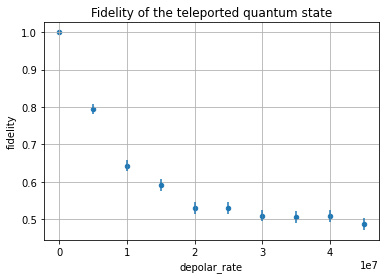

In [23]:
create_plot()

# Exercícios

1_ Plote o gráfico da fidelidade do teleporte realizado para uma taxa de defaseamento na ordem de $10^5$ Hz e, posteriomente, $10^7$ Hz. Compare os resultados com o gráfico obtido acima.

# Referências

[1] Michael A. Nielsen, Isaac L. Chuang. "Quantum Computation and Quantum Information: 10th Anniversary Edition". Cambridge University Press, 2010.

[2] https://docs.netsquid.org/latest-release/tutorial.simulation.html?highlight=full%20simulation